In [1]:
%matplotlib inline
import seaborn as sns

In [2]:
import numpy as np
import random

### Read MNIST

In [3]:
import os
import struct
import array
import numpy

def read(digits, dataset="training", path="."):
    """Loads MNIST files into 3D numpy arrays.
    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    Source: http://g.sweyla.com/blog/2012/mnist-numpy/
    MNIST: http://yann.lecun.com/exdb/mnist/
    **Parameters**
        :digits: list; digits we want to load
        :dataset: string; 'training' or 'testing'
        :path: string; path to the data set files
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    _, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [k for k in xrange(size) if lbl[k] in digits]
    N = len(ind)

    images = numpy.zeros((N, rows*cols), dtype=numpy.uint8)
    labels = numpy.zeros((N, 1), dtype=numpy.int8)
    for i in xrange(len(ind)):
        images[i] = numpy.array(img[ind[i]*rows*cols:
                                (ind[i]+1)*rows*cols])
        labels[i] = lbl[ind[i]]

    return images / 255.0, labels.flatten()

In [4]:
x_train, y_train = read(list(range(10)), "training", path="../../data/")
x_test, y_test = read(list(range(10)), "testing", path="../../data/")

In [5]:
y_train_t = np.zeros((60000,10))
for i,val in enumerate(y_train):
    y_train_t[i][val] = 1

In [6]:
y_test_t = np.zeros((10000,10))
for i,val in enumerate(y_test):
    y_test_t[i][val] = 1

### Z-transforming the X matrices

In [7]:
mean = x_train.mean(axis = 0)
std = x_train.std(axis = 0, ddof = 0)
x_train = np.nan_to_num((x_train - mean) / std)
x_test = np.nan_to_num((x_test - mean) / std)

### Activation funcs and their mapping

In [8]:
sigmoid = lambda z: 1.0/(1.0+np.exp(-z))
sigmoid_prime = lambda z: sigmoid(z)*(1-sigmoid(z))
funny_tanh = lambda z: 1.7159 * np.tanh(2.0/3.0 * z) + .001*z
funny_tanh_prime = lambda z: 1.7159 * 2.0 / 3.0 * (1.0 / np.cosh(2.0/3.0 * z))**2 + .001
relu = lambda z: z * (z > 0)
relu_prime = lambda z: z >= 0
leaky_relu = lambda z: np.maximum(.1*z, z)
leaky_relu_prime = lambda z: 1*(z>=0) + .1*(z<0)

In [9]:
afunc_mapping = {
    "sigmoid": [sigmoid, sigmoid_prime],
    "tanh": [funny_tanh, funny_tanh_prime],
    "relu": [relu, relu_prime],
    "leaky_relu": [leaky_relu, leaky_relu_prime]
}

In [ ]:
x = np.linspace(-10,10,200)
sns.plt.plot(x, afunc_mapping["leaky_relu"][0](x))
sns.plt.plot(x, afunc_mapping["leaky_relu"][1](x))

In [11]:
train_data = list(zip(x_train, y_train_t))
test_data = [x_test, y_test]

### Create Neural Network class

In [59]:
class NeuralNetwork():
    def __init__(self, layers_sizes, afunc, lmbda=0):
        self.layers_num = len(layers_sizes)
        self.layers_sizes = layers_sizes
        # x -> fan-out, y-> fan-in
        self.weights = [np.random.randn(x,y)/np.sqrt(y) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        self.biases = [np.random.randn(x) for x in layers_sizes[1:]]
        self.afunc = afunc_mapping[afunc][0]
        self.afunc_prime = afunc_mapping[afunc][1]
        self.train_accuracy = []
        self.test_accuracy = []
        self.lmbda = lmbda
        
        
    
    def forward_prop(self, x):
        activations = x
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            if i == self.layers_num:
                activations = sigmoid(W.dot(activations) + bias)
            else:
                activations = self.afunc(W.dot(activations) + bias)
        return activations
    
    def classification_accuracy(self, x_test = x_test, y_test = y_test, x_train = x_train, y_train=y_train):
        train_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_train])
        test_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_test])
        train_accuracy = sum(train_predictions == y_train) * 1.0 / len(y_train) * 100
        test_accuracy = sum(test_predictions == y_test) * 1.0 / len(y_test) * 100
        self.train_accuracy.append(train_accuracy)
        self.test_accuracy.append(test_accuracy)
        return (train_accuracy, test_accuracy)
    
    def cost_prime(self, a_L, y_true):
        """ Return the vector d(Loss) / d(a_L)"""
        return a_L - y_true
    
    def backprop(self, x, y_true):
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        activations = [x]
        zs = []
        # Forward prop
        activation = x
        
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            z = W.dot(activation) + bias
            zs.append(z)
            if i == self.layers_num:
                activation = sigmoid(z)
            else:
                activation = self.afunc(z)
            activations.append(activation)
        
        # Now do backprop
        delta = self.cost_prime(activations[-1], y_true) #* self.afunc_prime(zs[-1])
        biases_diff[-1] = delta
        weights_diff[-1] = np.outer(delta, activations[-2])
        
        for layer in xrange(2, self.layers_num):
            z = zs[-layer]
            sp = self.afunc_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            biases_diff[-layer] = delta
            weights_diff[-layer] = np.outer(delta, activations[-(layer+1)])

        return weights_diff, biases_diff
    
    def update_mini_batch(self, batch, learning_rate):
        n = len(batch)
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        for x, y in batch:
            w_diff, b_diff = self.backprop(x,y)
            weights_diff = [w+dw for w, dw in zip(weights_diff, w_diff)]
            biases_diff = [b+db for b, db in zip(biases_diff, b_diff)]
            
        self.weights = [(1-learning_rate*self.lmbda)*w - learning_rate*dw/n for w,dw in zip(self.weights, weights_diff)]
        self.biases = [b - learning_rate*db/n for b,db in zip(self.biases, biases_diff)]
    
    def SGD(self, train_data = None, batch_size = 10, epochs = 10, learning_rate = .1, test_data = None):
        if test_data:
            x_test, y_test = test_data
        n = len(train_data)
        for epoch in xrange(epochs):
            if epoch >= 10:
                learning_rate *= .95
            if epoch >= 20:
                learning_rate *= .85
            random.shuffle(train_data)
            mini_batches = [train_data[i:i+batch_size] for i in xrange(0,n,batch_size)]
            
            for batch in mini_batches:
                self.update_mini_batch(batch, learning_rate)
                
            if test_data:
                print "Epoch %s: Train/test accuracy = %s" % (epoch, self.classification_accuracy() )
            else:
                print "Epoch %s" % epoch

In [ ]:
class NeuralNetworkMomentum():
    def __init__(self, layers_sizes, afunc, momentum = 0):
        self.layers_num = len(layers_sizes)
        self.layers_sizes = layers_sizes
        # x -> fan-out, y-> fan-in
        if afunc in ["relu", "leaky_relu"]:
            self.weights = [np.random.randn(x,y)/np.sqrt(2.0/y) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        else:
            self.weights = [np.random.randn(x,y)/np.sqrt(y) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        self.biases = [np.random.randn(x) for x in layers_sizes[1:]]
        self.afunc = afunc_mapping[afunc][0]
        self.afunc_prime = afunc_mapping[afunc][1]
        self.train_accuracy = []
        self.test_accuracy = []
        self.weight_momentum = [np.zeros((x,y)) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        self.bias_momentum = [np.zeros(x) for x in layers_sizes[1:]]
        self.momentum = momentum
        
        
    
    def forward_prop(self, x):
        activations = x
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            if i == self.layers_num:
                activations = sigmoid(W.dot(activations) + bias)
            else:
                activations = self.afunc(W.dot(activations) + bias)
        return activations
    
    def classification_accuracy(self, x_test = x_test, y_test = y_test, x_train = x_train, y_train=y_train):
        train_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_train])
        test_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_test])
        train_accuracy = sum(train_predictions == y_train) * 1.0 / len(y_train) * 100
        test_accuracy = sum(test_predictions == y_test) * 1.0 / len(y_test) * 100
        self.train_accuracy.append(train_accuracy)
        self.test_accuracy.append(test_accuracy)
        return (train_accuracy, test_accuracy)
    
    def cost_prime(self, a_L, y_true):
        """ Return the vector d(Loss) / d(a_L)"""
        return a_L - y_true
    
    def backprop(self, x, y_true):
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        activations = [x]
        zs = []
        # Forward prop
        activation = x
        
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            z = W.dot(activation) + bias
            zs.append(z)
            if i == self.layers_num:
                activation = sigmoid(z)
            else:
                activation = self.afunc(z)
            activations.append(activation)
        
        # Now do backprop
        delta = self.cost_prime(activations[-1], y_true) #* self.afunc_prime(zs[-1])
        biases_diff[-1] = delta
        weights_diff[-1] = np.outer(delta, activations[-2])
        
        for layer in xrange(2, self.layers_num):
            z = zs[-layer]
            sp = self.afunc_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            biases_diff[-layer] = delta
            weights_diff[-layer] = np.outer(delta, activations[-(layer+1)])

        return weights_diff, biases_diff
    
    def update_mini_batch(self, batch, learning_rate):
        n = len(batch)
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        for x, y in batch:
            w_diff, b_diff = self.backprop(x,y)
            weights_diff = [w+dw for w, dw in zip(weights_diff, w_diff)]
            biases_diff = [b+db for b, db in zip(biases_diff, b_diff)]
            
        self.weight_momentum = [(self.momentum * m) + learning_rate*dw/n for m,dw in zip(self.weight_momentum, weights_diff)]  
        self.bias_momentum = [(self.momentum * m) + learning_rate*db/n for m,db in zip(self.bias_momentum, biases_diff)]  
        
        self.weights = [w - dw for w,dw in zip(self.weights, self.weight_momentum)]
        self.biases = [b - db for b,db in zip(self.biases, self.bias_momentum)]
    
    def SGD(self, train_data = None, batch_size = 10, epochs = 10, learning_rate = .1, test_data = None):
        if test_data:
            x_test, y_test = test_data
        n = len(train_data)
        for epoch in xrange(epochs):
            if epoch >= 10:
                learning_rate *= .95
            if epoch >= 20:
                learning_rate *= .85
            random.shuffle(train_data)
            mini_batches = [train_data[i:i+batch_size] for i in xrange(0,n,batch_size)]
            
            for batch in mini_batches:
                self.update_mini_batch(batch, learning_rate)
                
            if test_data:
                print "Epoch %s: Train/test accuracy = %s" % (epoch, self.classification_accuracy() )
            else:
                print "Epoch %s" % epoch

### NN using Sigmoid

In [16]:
clf_sigmoid_double = NeuralNetwork([784,100,10], "sigmoid")

In [ ]:
clf_sigmoid_double.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 15)

In [ ]:
clf_sigmoid_half = NeuralNetwork([784,25,10], "sigmoid")
clf_sigmoid_half.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 15)

### Sigmoid 2 hidden

In [ ]:
clf_sigmoid_two_layer = NeuralNetwork([784,25,25,10], "sigmoid")
clf_sigmoid_two_layer.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 15)

### Sigmoid with regularization

In [62]:
clf_sigmoid_l1 = NeuralNetwork([784,50,10], afunc = "sigmoid", lmbda=0.001)

In [63]:
clf_sigmoid_l1.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 15)

Epoch 0: Train/test accuracy = (94.049999999999997, 93.620000000000005)
Epoch 1: Train/test accuracy = (95.068333333333328, 94.25)
Epoch 2: Train/test accuracy = (95.516666666666666, 94.549999999999997)
Epoch 3: Train/test accuracy = (95.526666666666671, 94.789999999999992)
Epoch 4: Train/test accuracy = (95.841666666666669, 94.910000000000011)
Epoch 5: Train/test accuracy = (95.946666666666673, 95.109999999999999)
Epoch 6: Train/test accuracy = (96.053333333333342, 95.170000000000002)
Epoch 7: Train/test accuracy = (96.123333333333335, 95.359999999999999)
Epoch 8: Train/test accuracy = (96.296666666666667, 95.289999999999992)
Epoch 9: Train/test accuracy = (96.278333333333336, 95.459999999999994)
Epoch 10: Train/test accuracy = (96.25833333333334, 95.280000000000001)
Epoch 11: Train/test accuracy = (96.448333333333338, 95.52000000000001)
Epoch 12: Train/test accuracy = (96.398333333333326, 95.560000000000002)
Epoch 13: Train/test accuracy = (96.480000000000004, 95.459999999999994)
Epo

In [ ]:
clf_sigmoid_l2 = NeuralNetwork([784,50,10], afunc = "sigmoid", lmbda=0.0001)
clf_sigmoid_l2.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 15)

### NN using Tanh

In [21]:
clf_tanh = NeuralNetwork([784,50,10], "tanh")

In [ ]:
clf_tanh.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 15)

### NN using ReLu

In [54]:
clf_relu2 = NeuralNetwork([784,50,10], "relu")

In [ ]:
clf_relu2.SGD(train_data, test_data=test_data, learning_rate = .0005, epochs=30, batch_size = 15)

In [ ]:
clf_lrelu = NeuralNetwork([784,50,10], "relu")
clf_lrelu.SGD(train_data, test_data=test_data, learning_rate = .005, epochs=30, batch_size = 10)

In [ ]:
clf_relu3 = NeuralNetwork([784,50,10], "relu")
clf_relu3.SGD(train_data, test_data=test_data, learning_rate = .001, epochs=30, batch_size = 15)

### Plot training vs test accuracy with epochs

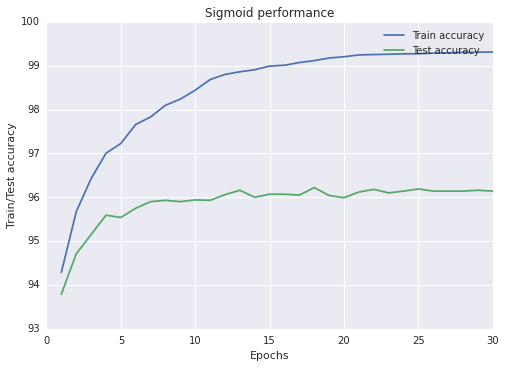

In [29]:
x = [i+1 for i in xrange(30)]
sigmoid_train = [94.286666666666662, 95.666666666666671, 96.425000000000011, 97.00333333333333, 97.228333333333339, 97.661666666666662, 97.831666666666663, 98.098333333333329, 98.240000000000009, 98.443333333333342, 98.685000000000002, 98.801666666666662, 98.861666666666665, 98.909999999999997, 98.99166666666666, 99.01166666666667, 99.073333333333338, 99.11666666666666, 99.176666666666662, 99.204999999999998, 99.24666666666667, 99.25500000000001, 99.26166666666667, 99.271666666666675, 99.273333333333341, 99.288333333333327, 99.295000000000002, 99.304999999999993, 99.308333333333337, 99.313333333333333]
sigmoid_test = [93.789999999999992, 94.710000000000008, 95.150000000000006, 95.590000000000003, 95.540000000000006, 95.75, 95.899999999999991, 95.930000000000007, 95.899999999999991, 95.939999999999998, 95.930000000000007, 96.060000000000002, 96.159999999999997, 96.0, 96.069999999999993, 96.069999999999993, 96.049999999999997, 96.219999999999999, 96.040000000000006, 95.989999999999995, 96.120000000000005, 96.179999999999993, 96.099999999999994, 96.140000000000001, 96.189999999999998, 96.140000000000001, 96.140000000000001, 96.140000000000001, 96.159999999999997, 96.140000000000001]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance")
sns.plt.legend()

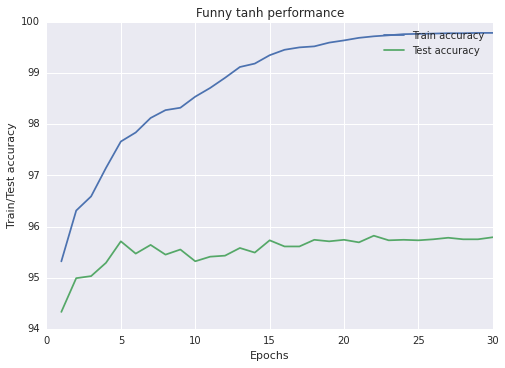

In [30]:
x = [i+1 for i in xrange(30)]
tanh_train = [95.318333333333342, 96.311666666666667, 96.588333333333338, 97.14500000000001, 97.661666666666662, 97.838333333333338, 98.12166666666667, 98.275000000000006, 98.321666666666658, 98.538333333333341, 98.708333333333329, 98.906666666666666, 99.118333333333325, 99.185000000000002, 99.348333333333343, 99.454999999999998, 99.501666666666665, 99.521666666666661, 99.594999999999999, 99.638333333333335, 99.688333333333333, 99.718333333333334, 99.73833333333333, 99.760000000000005, 99.766666666666666, 99.771666666666675, 99.778333333333336, 99.778333333333336, 99.784999999999997, 99.784999999999997]
tanh_test = [94.329999999999998, 94.989999999999995, 95.030000000000001, 95.289999999999992, 95.709999999999994, 95.469999999999999, 95.640000000000001, 95.450000000000003, 95.549999999999997, 95.320000000000007, 95.409999999999997, 95.430000000000007, 95.579999999999998, 95.489999999999995, 95.730000000000004, 95.609999999999999, 95.609999999999999, 95.740000000000009, 95.709999999999994, 95.740000000000009, 95.689999999999998, 95.820000000000007, 95.730000000000004, 95.740000000000009, 95.730000000000004, 95.75, 95.780000000000001, 95.75, 95.75, 95.789999999999992]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, tanh_train,  label = "Train accuracy" )
sns.plt.plot(x, tanh_test,  label = "Test accuracy" )
sns.plt.title("Funny tanh performance")
sns.plt.legend()

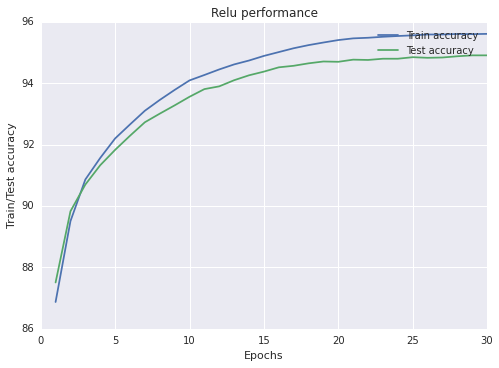

In [56]:
x = [i+1 for i in xrange(30)]
relu_train = [86.873333333333335, 89.50833333333334, 90.864999999999995, 91.566666666666663, 92.201666666666668, 92.658333333333331, 93.105000000000004, 93.456666666666663, 93.783333333333331, 94.093333333333334, 94.269999999999996, 94.451666666666668, 94.615000000000009, 94.741666666666674, 94.891666666666666, 95.016666666666666, 95.141666666666666, 95.243333333333339, 95.328333333333333, 95.408333333333331, 95.463333333333338, 95.483333333333334, 95.515000000000001, 95.540000000000006, 95.561666666666667, 95.590000000000003, 95.590000000000003, 95.606666666666655, 95.601666666666659, 95.609999999999999]
relu_test = [87.510000000000005, 89.829999999999998, 90.700000000000003, 91.329999999999998, 91.829999999999998, 92.290000000000006, 92.730000000000004, 93.010000000000005, 93.280000000000001, 93.560000000000002, 93.810000000000002, 93.899999999999991, 94.099999999999994, 94.260000000000005, 94.379999999999995, 94.52000000000001, 94.569999999999993, 94.650000000000006, 94.710000000000008, 94.699999999999989, 94.769999999999996, 94.760000000000005, 94.799999999999997, 94.799999999999997, 94.849999999999994, 94.829999999999998, 94.840000000000003, 94.879999999999995, 94.910000000000011, 94.910000000000011]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, relu_train,  label = "Train accuracy" )
sns.plt.plot(x, relu_test,  label = "Test accuracy" )
sns.plt.title("Relu performance")
sns.plt.legend()

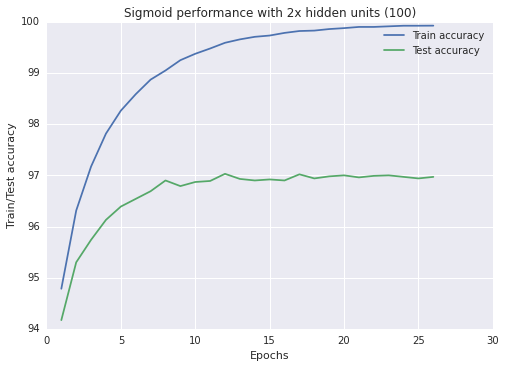

In [44]:
x = [i+1 for i in xrange(26)]
sigmoid_train =[94.783333333333331, 96.311666666666667, 97.173333333333332, 97.816666666666663, 98.265000000000001, 98.586666666666673, 98.87166666666667, 99.050000000000011, 99.251666666666665, 99.376666666666665, 99.480000000000004, 99.591666666666669, 99.658333333333331, 99.708333333333329, 99.733333333333334, 99.784999999999997, 99.821666666666658, 99.829999999999998, 99.859999999999999, 99.87833333333333, 99.901666666666671, 99.901666666666671, 99.913333333333327, 99.924999999999997, 99.924999999999997, 99.926666666666662]
sigmoid_test = [94.170000000000002, 95.299999999999997, 95.740000000000009, 96.13000000000001, 96.390000000000001, 96.540000000000006, 96.689999999999998, 96.899999999999991, 96.789999999999992, 96.870000000000005, 96.890000000000001, 97.030000000000001, 96.930000000000007, 96.899999999999991, 96.920000000000002, 96.899999999999991, 97.019999999999996, 96.939999999999998, 96.980000000000004, 97.0, 96.960000000000008, 96.989999999999995, 97.0, 96.969999999999999, 96.939999999999998, 96.969999999999999]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with 2x hidden units (100)")
sns.plt.legend()

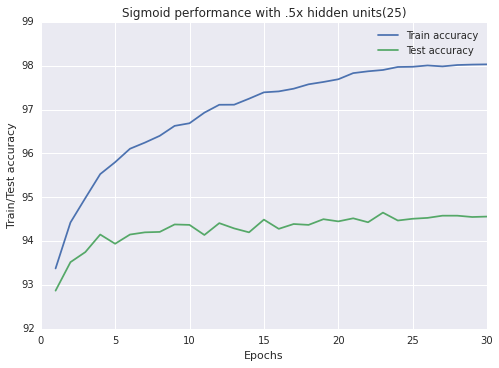

In [45]:
x = [i+1 for i in xrange(30)]
sigmoid_train = [93.376666666666665, 94.424999999999997, 94.981666666666669, 95.528333333333336, 95.799999999999997, 96.106666666666669, 96.24666666666667, 96.401666666666657, 96.628333333333345, 96.688333333333333, 96.930000000000007, 97.109999999999999, 97.111666666666665, 97.248333333333335, 97.393333333333331, 97.414999999999992, 97.476666666666674, 97.576666666666668, 97.629999999999995, 97.691666666666663, 97.831666666666663, 97.873333333333335, 97.903333333333336, 97.971666666666664, 97.976666666666674, 98.006666666666661, 97.984999999999999, 98.016666666666666, 98.026666666666657, 98.031666666666666]
sigmoid_test = [92.86999999999999, 93.52000000000001, 93.75, 94.150000000000006, 93.939999999999998, 94.150000000000006, 94.199999999999989, 94.210000000000008, 94.379999999999995, 94.370000000000005, 94.140000000000001, 94.410000000000011, 94.289999999999992, 94.199999999999989, 94.489999999999995, 94.280000000000001, 94.390000000000001, 94.370000000000005, 94.5, 94.450000000000003, 94.52000000000001, 94.430000000000007, 94.650000000000006, 94.469999999999999, 94.510000000000005, 94.530000000000001, 94.579999999999998, 94.579999999999998, 94.549999999999997, 94.560000000000002]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with .5x hidden units(25)")
sns.plt.legend()

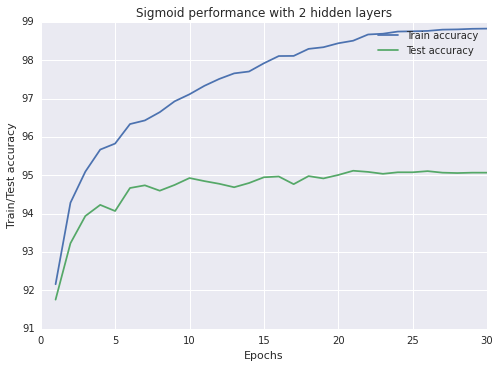

In [46]:
x = [i+1 for i in xrange(30)]
sigmoid_train = clf_sigmoid_two_layer.train_accuracy
sigmoid_test = clf_sigmoid_two_layer.test_accuracy

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with 2 hidden layers")
sns.plt.legend()

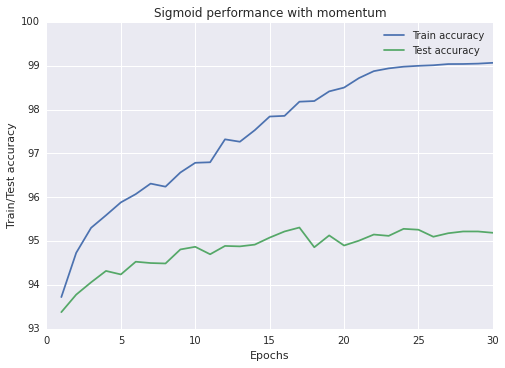

In [47]:
x = [i+1 for i in xrange(30)]
sigmoid_train = [93.723333333333329, 94.733333333333334, 95.303333333333327, 95.588333333333324, 95.883333333333326, 96.071666666666673, 96.311666666666667, 96.241666666666674, 96.564999999999998, 96.786666666666662, 96.798333333333332, 97.321666666666658, 97.266666666666666, 97.530000000000001, 97.841666666666669, 97.856666666666669, 98.180000000000007, 98.194999999999993, 98.414999999999992, 98.501666666666665, 98.718333333333334, 98.876666666666665, 98.939999999999998, 98.978333333333339, 98.998333333333335, 99.01166666666667, 99.038333333333327, 99.039999999999992, 99.048333333333332, 99.066666666666663]
sigmoid_test =[93.379999999999995, 93.780000000000001, 94.060000000000002, 94.320000000000007, 94.239999999999995, 94.530000000000001, 94.5, 94.489999999999995, 94.810000000000002, 94.870000000000005, 94.699999999999989, 94.890000000000001, 94.879999999999995, 94.920000000000002, 95.079999999999998, 95.219999999999999, 95.309999999999988, 94.859999999999999, 95.13000000000001, 94.899999999999991, 95.009999999999991, 95.150000000000006, 95.120000000000005, 95.280000000000001, 95.260000000000005, 95.099999999999994, 95.179999999999993, 95.219999999999999, 95.219999999999999, 95.189999999999998]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with momentum")
sns.plt.legend()

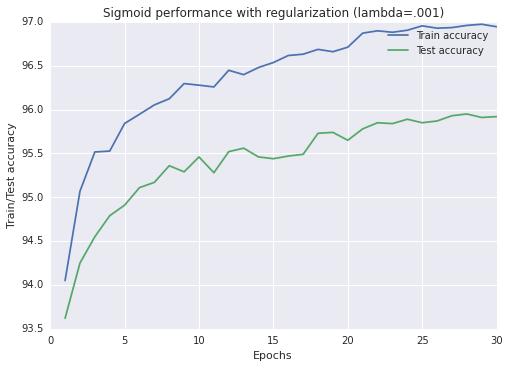

In [64]:
x = [i+1 for i in xrange(30)]
sigmoid_train = clf_sigmoid_l1.train_accuracy
sigmoid_test = clf_sigmoid_l1.test_accuracy

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with regularization (lambda=.001)")
sns.plt.legend()

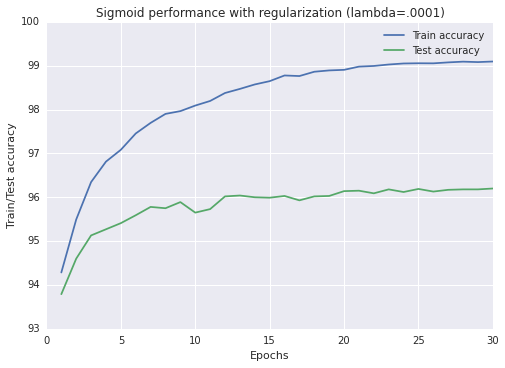

In [65]:
x = [i+1 for i in xrange(30)]
sigmoid_train = [94.284999999999997, 95.493333333333325, 96.346666666666664, 96.813333333333333, 97.083333333333329, 97.454999999999998, 97.696666666666658, 97.901666666666671, 97.965000000000003, 98.091666666666669, 98.196666666666658, 98.37833333333333, 98.471666666666664, 98.573333333333338, 98.648333333333341, 98.778333333333336, 98.765000000000001, 98.86333333333333, 98.893333333333331, 98.906666666666666, 98.980000000000004, 98.995000000000005, 99.028333333333336, 99.051666666666677, 99.056666666666672, 99.055000000000007, 99.076666666666668, 99.093333333333334, 99.083333333333329, 99.096666666666664]
sigmoid_test = [93.789999999999992, 94.599999999999994, 95.13000000000001, 95.269999999999996, 95.409999999999997, 95.590000000000003, 95.780000000000001, 95.75, 95.890000000000001, 95.650000000000006, 95.730000000000004, 96.02000000000001, 96.040000000000006, 96.0, 95.989999999999995, 96.030000000000001, 95.930000000000007, 96.02000000000001, 96.030000000000001, 96.140000000000001, 96.150000000000006, 96.090000000000003, 96.179999999999993, 96.120000000000005, 96.189999999999998, 96.13000000000001, 96.170000000000002, 96.179999999999993, 96.179999999999993, 96.200000000000003]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with regularization (lambda=.0001)")
sns.plt.legend()